In [1]:
import warnings

import pandas as pd
import numpy as np
import jenkspy
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=RuntimeWarning, module="deap.creator")
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

In [2]:
df = pd.read_csv("../../data/df_score.csv", index_col=[0])

In [ ]:
df["date_mensuelle"] = pd.to_datetime(df["date_mensuelle"])
df['date_trimestrielle'] = df['date_mensuelle'].dt.year.astype(str) + '_' + df['date_mensuelle'].dt.quarter.astype(str)

# Jenks

In [4]:
scores_clients = df["Score_ind"]
nombre_de_classes = 6 

breaks = jenkspy.jenks_breaks(scores_clients, nombre_de_classes)
print(breaks)

[0.0, 106.38297872340424, 314.8936170212765, 434.0425531914893, 540.4255319148936, 685.1063829787233, 1000.0]


In [11]:
breaks = [0.0, 106, 314, 434, 540, 685, 800]

df["Classes"] = np.digitize(df["Score_ind"], bins=sorted(breaks))

resultats = df.groupby("Classes").agg(
    moyenne_TARGET=("TARGET", "mean"),
    nb_individus=("TARGET", "size")
)
resultats['taux_individus'] = (resultats['nb_individus'] / df.shape[0]) * 100

print(resultats)

         moyenne_TARGET  nb_individus  taux_individus
Classes                                              
1              0.175582          9665        3.157393
2              0.110399         78280       25.572757
3              0.079621         50439       16.477572
4              0.067263         70886       23.157262
5              0.050027         56250       18.375927
6              0.038518         27416        8.956345
7              0.037203         13171        4.302744


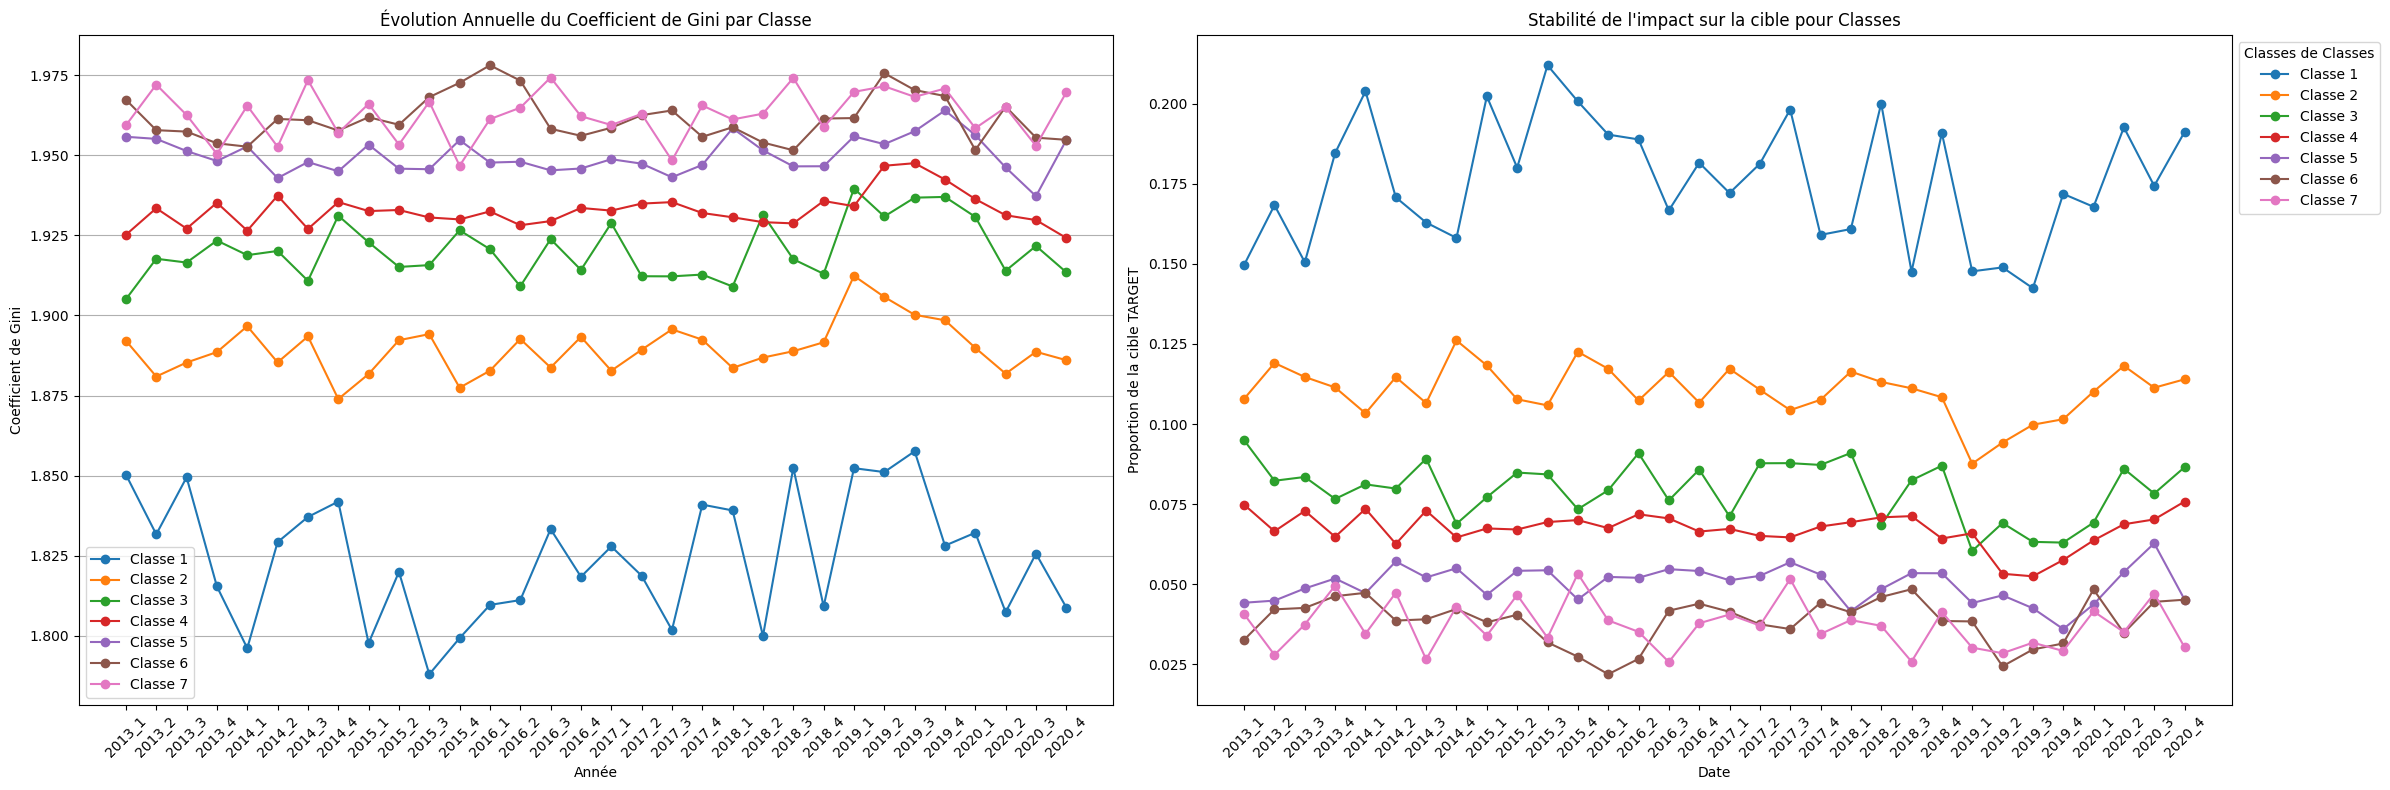

In [13]:
def gini_coefficient(values):
    sorted_values = np.sort(values)
    n = len(values)
    cumulative_values_sum = np.cumsum(sorted_values)
    gini_index = (2 * np.sum(cumulative_values_sum) / (n * np.sum(sorted_values))) - (n + 1) / n
    return 1 - gini_index

fig, axes = plt.subplots(1, 2, figsize=(24, 8)) 

for classe in range(1, 8): 
    df_classe = df[df['Classes'] == classe][["date_trimestrielle", "TARGET"]]
    grouped = df_classe.groupby(df_classe['date_trimestrielle'])["TARGET"]
    gini_per_year = grouped.apply(gini_coefficient)
    
    axes[0].plot(gini_per_year.index, gini_per_year, label=f'Classe {classe}', marker='o')

axes[0].set_title('Évolution Annuelle du Coefficient de Gini par Classe')
axes[0].set_xlabel('Année')
axes[0].set_ylabel('Coefficient de Gini')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y')

def plot_stability_taux(ax, train, variable):
    stability_df = train.groupby(['date_trimestrielle', variable])['TARGET'].mean().unstack()
    stability_df['stability'] = stability_df.std(axis=1) / stability_df.mean(axis=1)
    
    for class_label in stability_df.drop('stability', axis=1).columns:
        values = stability_df[class_label]
        ax.plot(stability_df.index, values, label=f'Classe {class_label}', marker='o')
    
    ax.set_title(f'Stabilité de l\'impact sur la cible pour {variable}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Proportion de la cible TARGET')
    ax.legend(title=f'Classes de {variable}', loc='upper left', bbox_to_anchor=(1, 1))
    ax.tick_params(axis='x', rotation=45)

plot_stability_taux(axes[1], df, 'Classes')

plt.tight_layout()
plt.show()

In [14]:
df.to_csv("../../data/df_segmentation.csv")